In [1]:
import numpy as np
import cv2
#import math
import matplotlib.pyplot as plt
import matplotlib
#import scipy.stats as stats
from skimage.exposure import match_histograms

matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
path = './samples/'

## DEMO


Sacamos de la imagen dada los parámetros de transformación.
Para ello delimitamos el carril usado mediante 2 líneas laterales y 1 línea perpendicular, que marcará la frontera de la zona de trabajo.
Sacamos 4 puntos de interés, las 2 justamente donde está el capot del coche y otros 2 en la intersección de las líneas.

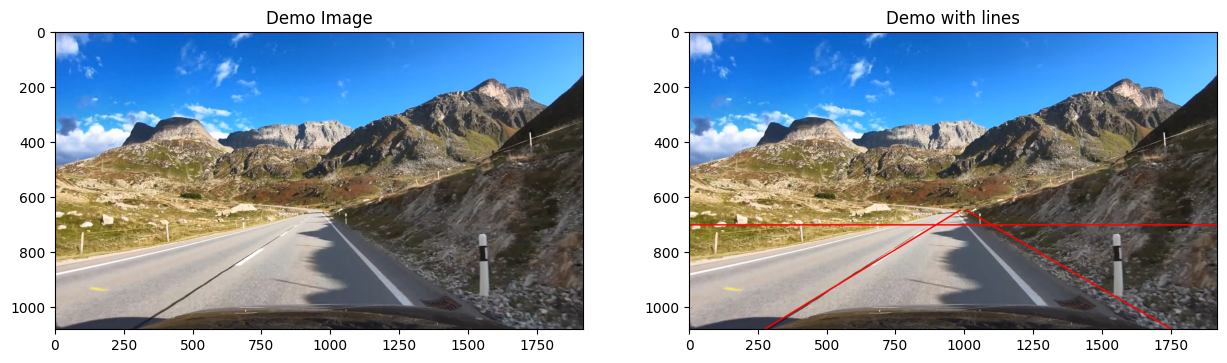

In [2]:
demo = cv2.imread(path + '11.png', -1)
demo = cv2.cvtColor(demo, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
demo_copy = np.copy(demo)
h,w,c = demo_copy.shape
plt.imshow(demo_copy)
plt.title('Demo Image')

pt1 = (275,h)
pt2 = (985, int (0.6*h))
cv2.line(demo,pt1,pt2,(255,0,0),3,cv2.LINE_AA)
pt3 = (1750,h)
pt4 = (1005, int (0.6*h))
cv2.line(demo,pt3,pt4,(255,0,0),3,cv2.LINE_AA)
pt5 = (0, int (0.65*h))
pt6 = (w, int (0.65*h))
cv2.line(demo,pt5,pt6,(255,0,0),3,cv2.LINE_AA)

plt.subplot(1,2,2)
plt.imshow(demo)
plt.title('Demo with lines')
plt.show()


In [3]:
def obtener_homografia():
    
    # Points of the rectangle in the road
    pts_src = np.array([[275, h],[1750, h],[896.25, int (0.65*h)],[1098.125, int (0.65*h)]])

    # Points of a rectangle without perspective with r=1.6
    pts_dst = np.array([[150, 1105], [650, 1105], [150, 300],[650, 300]])

    # Calculate Homography
    M, status = cv2.findHomography(pts_src, pts_dst)
    return M

Mapeamos los cuatro puntos obtenidos en un rectangulo y calculamos la matriz de transfomación.
Al aplicar la tranformación en la imágen inicial obtenemos otra, sin perspectiva alguna.

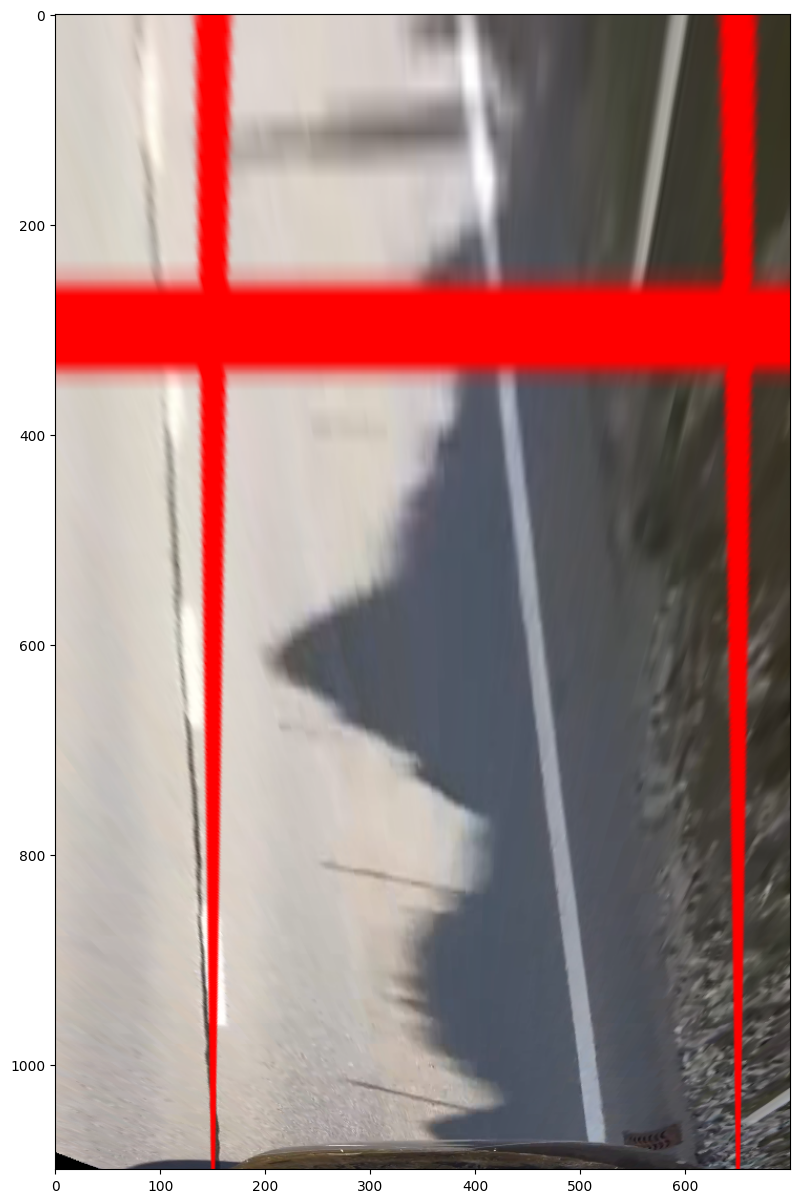

In [4]:
# Warp source image to destination based on homography
M = obtener_homografia()
no_perspective = cv2.warpPerspective(demo, M, (700,1100))

# Show image without perspective
plt.imshow(no_perspective)
plt.show()

Hacemos el Histogram matching con una imagen de referencia

In [5]:
def reference_histogram (image, verbose=False):

    ref = cv2.imread(path+'ref2.png',0)
    if (verbose):
        plt.subplot(2,2,1)
        #plt.hist(ref.ravel(),256,[0,255])
        plt.imshow(image,cmap = 'gray')
        plt.title("Reference histogram")
    matched = match_histograms(image, ref)
    if (verbose):
        plt.subplot(2,2,2)
        plt.hist(matched.ravel(),256,[0,255])
        plt.title("New image histogram")
    return matched


Binarizamos la imagen resultante y obtenemos las líneas de carretera sin distorción.

In [6]:
def binarizar(imagen, verbose=False):
    lab = cv2.cvtColor(imagen,cv2.COLOR_RGB2Lab)
    #binarized_no_perspective = cv2.adaptiveThreshold(lab, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, -17)
    matched_no_perspective = reference_histogram(lab [:,:,0], verbose)
    
    _,binarized_no_perspective = cv2.threshold(matched_no_perspective, 170, 255, cv2.THRESH_BINARY)
    
    if verbose:
        plt.subplot(2,2,3)
        #plt.imshow(matched_no_perspective,cmap ='gray')
        plt.imshow(binarized_no_perspective,cmap ='gray')
        plt.title("No perspective binarization matched")
        
    return binarized_no_perspective

Calculamos el histograma de la imagen binarizada

In [7]:
def calc_histograma(binarized_no_perspective, verbose = False):
    
    histogram = np.sum(binarized_no_perspective[int(binarized_no_perspective.shape[0]/2):,:], axis=0)  
    
    if verbose:
        plt.subplot(2,2,4).plot(histogram)
        plt.title("Histogram")
        plt.show()
        
    return histogram

Buscamos los picos en el histograma. Cada pico indica la posición de las lineas de la carretera.

In [8]:
def peaks(histogram, verbose = False):
    middle_point = int(histogram.shape[0]/2)
    if verbose:
        print(middle_point)
        
    left_peak = np.max(histogram[0:middle_point])
    left_index = np.where(histogram ==left_peak)[0][0]
    #left_index = histogram.index(left_peak)
    right_peak = np.max(histogram[middle_point:histogram.shape[0]])
    #print('rigth p: ',right_peak)
    right_index = np.where(histogram[middle_point:histogram.shape[0]] == right_peak)[0][0] + middle_point
    return left_index,right_index

La ventata deslizante empieza en el punto, que es el máximo del histograma calculada. Si detecta que la cantidad de pixeles blancos, que esten dentro de la ventana, supera el umbral, la ventana ajusta su posición horizontal. En caso contrario se displaza verticalmente si ajustar la posición horizontal.

In [9]:
def poner_puntos(img, p_base, extra, ancho):
    alto = 11 # window height
    t = int(0.05*alto*ancho*2)
    #print(img.shape)
    p_base =p_base + extra
    img_h, img_w = img.shape
    
    puntos = np.zeros ( [(int(img_h/alto) - 1),2] ,dtype='int32') #(fila,columna)
    
#    for i in range(3,int(img_h/alto) - int ((img_h/alto)*0.2)):
    #pos = 0
    for i in range(3,int(img_h/alto) - 1):
        aux = img[img_h - (alto * (i+1)):img_h - (alto * i), p_base - ancho : p_base + ancho]
        unos = np.where(aux == 255)
        puntos[i,:] = ([p_base,img_h - (alto * i)])
        if (np.size(unos) > t):
            p_base = (p_base - ancho) + int(np.mean(unos[1]))
            #puntos[pos,:] = ([p_base,img_h - (alto * i)])
            #pos += 1
            
    puntos = puntos[puntos[:,0] != 0]
    puntos[:,0] = puntos[:,0] - extra
    return puntos

Amplia la imagen dada con 2 bandas laterales y llama la subfunción 'poner-puntos' que a su vez implementa el algoritmo de la ventata deslizante. La invoca 2 veces, una vez para cada linea.

In [10]:
def sliding_window(img, p_base_i, ancho_i, p_base_d, ancho_d,verbose):
    # ancho = 100 # window width
    img_h, img_w = img.shape
    #extra = np.maximum(ancho_i,ancho_d)
    img_ancho = np.zeros((img_h, img_w + ancho_i + ancho_d),dtype='int32')
    #print(img_ancho.shape)
    img_ancho[:,ancho_i:img_w+ancho_i] = img
    if verbose:
        plt.subplot(3,1,1)
        plt.title('in')
        plt.imshow(img);
        plt.subplot(3,1,2)
        plt.title('out')
        plt.imshow(img_ancho);
        plt.show()
    
    puntos_i = poner_puntos(img_ancho, p_base_i, ancho_i, ancho_i)
    puntos_d = poner_puntos(img_ancho, p_base_d, ancho_i, ancho_d)
    return puntos_i, puntos_d

Dado la nube de puntos busca la mejor curva polinomica que aproxime a este nube. A continuación evalua la nuve de puntos dado en esta funcion, así reajustando su posición en la eje X

In [11]:
def lineas_laterales(histograma, binarized_no_perspective, verbose = False): 

    pico_i, pico_d = peaks(histograma, verbose)
    #print('pico i: ', pico_i, ', pico d: ', pico_d)
    puntos_i, puntos_d = sliding_window(binarized_no_perspective, pico_i, 100, pico_d, 75,  verbose)
    
    # tst = drawPoints(np.copy(binarized_no_perspective), puntos_i)
    # tst = drawPoints(tst, puntos_d)
    # plt.subplot(2,1,1)
    # plt.imshow(tst)
    # plt.show()
    
    #dummy = np.arange(100, 1080, 10, dtype='int32')
    z_d = np.polyfit(puntos_d[:,1], puntos_d[:,0], 5) # ajuste polynomial
    #puntos_d = np.ones((dummy.shape[0], 2),dtype='int32')
    puntos_d[:,0] = np.polyval(z_d,puntos_d[:,1]) # obteniendo nuevos puntos
    #puntos_d[:,0] = np.polyval(z_d,dummy) # obteniendo nuevos puntos
    #puntos_d[:,1] = dummy
    
    z_i = np.polyfit(puntos_i[:,1], puntos_i[:,0], 5) # ajuste polynomial
    #puntos_i = np.ones((dummy.shape[0], 2),dtype='int32')
    puntos_i[:,0] = np.polyval(z_i,puntos_i[:,1]) # obteniendo nuevos puntos
    #puntos_i[:,0] = np.polyval(z_i,dummy) # obteniendo nuevos puntos
    #puntos_i[:,1] = dummy
    
    # tst = drawPoints(np.copy(binarized_no_perspective), puntos_i)
    # tst = drawPoints(tst, puntos_d)
    # plt.subplot(2,1,2)
    # plt.imshow(tst)
    # plt.show()
    
    if verbose:
        plt.subplot(1,2,2)
        plt.imshow(binarized_no_perspective, cmap='gray')
        plt.title('image')
        plt.show()
        
    return puntos_i, z_i, puntos_d, z_d

Dibuja los puntos dados en la imagen

In [12]:
def drawPoints (image, puntos):
    for i in range(np.size(puntos[:,0])):
        image = cv2.circle(image, (puntos[i,0],puntos[i,1]), 5, (200,200,200), -1)
    return image

aumentamos el nube de puntos con la coordenada homogenea y aplicamos la matriz de transformación. Antes de devolver dividimos por la coordenada homogenea y obtenemos los puntos en el espacio M

In [13]:
def transformar_linea(puntos_c):
    a,b = puntos_c.shape
    linea_h = np.ones((b+1,a),dtype='int32')
    puntos_c=puntos_c.transpose()
    linea_h[0,:] = puntos_c[0,:]
    linea_h[1,:] = puntos_c[1,:]
    new_puntos = inv_M@linea_h
    new_puntos_c = new_puntos/new_puntos[2,:]
    puntos_t = np.ones((b,a),dtype='int32')
    puntos_t[0,:] = new_puntos_c[0,:]
    puntos_t[1,:] = new_puntos_c[1,:]
    puntos_t = puntos_t.transpose()
    return puntos_t

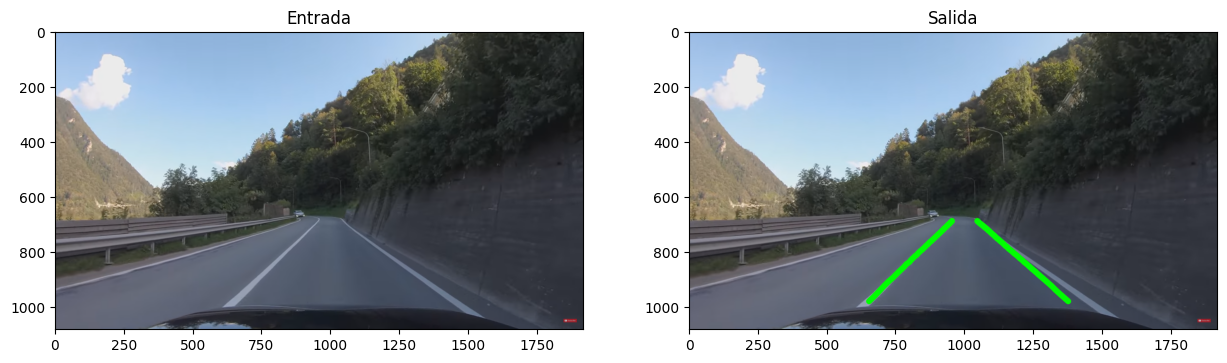

In [15]:
# MAIN
# abrimos la imagen
image_name = path + '01.png'
image = cv2.imread(image_name, -1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

M = obtener_homografia()
inv_M = np.linalg.inv(M)

no_perspective = cv2.warpPerspective(np.copy(image), M, (700,1100))
binarized_no_perspective = binarizar(no_perspective, False)
histograma = calc_histograma(binarized_no_perspective, False)
    
puntos_i, z_i, puntos_d, z_d = lineas_laterales(histograma, binarized_no_perspective, False)
#h,w,c = no_perspective.shape

h,w,_ = image.shape

#puntos_c = linea_central(z_i,z_d, puntos_i, puntos_d)

puntos_it = transformar_linea(puntos_i)
puntos_dt = transformar_linea(puntos_d)

# puntos_it = puntos_it[puntos_it[:,0] >= 0]
# puntos_it = puntos_it[puntos_it[:,1] >= 0]
# puntos_dt = puntos_dt[puntos_dt[:,0] >= 0]
# puntos_dt = puntos_dt[puntos_dt[:,1] >= 0]
no_perspective = cv2.polylines(np.copy(image), np.int32([puntos_it]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)

no_perspective = cv2.polylines(no_perspective, np.int32([puntos_dt]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
plt.subplot(2,2,1)
plt.title('Entrada')
plt.imshow(image)

plt.subplot(2,2,2)
plt.title('Salida')
plt.imshow(no_perspective)

plt.show()

In [16]:
# MAIN

#abrimos video
captura = cv2.VideoCapture(path+'testVideo.avi')
puntos_acumulados_i = []
puntos_acumulados_d = []
while (captura.isOpened()):
    ret, image = captura.read()
    if ret == True:
        #cv2.imshow('video', image)

        M = obtener_homografia()
        inv_M = np.linalg.inv(M)

        no_perspective = cv2.warpPerspective(np.copy(image), M, (700,1100))
        binarized_no_perspective = binarizar(no_perspective,False)
        histograma = calc_histograma(binarized_no_perspective, False)

        try: 
      
            puntos_i, z_i, puntos_d, z_d = lineas_laterales(histograma, binarized_no_perspective, False)
            #h,w,c = no_perspective.shape

            h,w,_ = image.shape

            #puntos_c = linea_central(z_i,z_d, puntos_i, puntos_d, False)
            puntos_it = transformar_linea(puntos_i)
            puntos_dt = transformar_linea(puntos_d)
            
            puntos_acumulados_i.append(puntos_it)
            puntos_acumulados_d.append(puntos_dt)
            if(len(puntos_acumulados_i)>5):
                puntos_acumulados_i.pop(0)
                puntos_acumulados_d.pop(0)
            puntos_it =np.mean(puntos_acumulados_i, axis = 0)
            puntos_dt =np.mean(puntos_acumulados_d, axis = 0)

            # puntos_it = puntos_it[puntos_it[:,0] >= 0]
            # puntos_it = puntos_it[puntos_it[:,1] >= 0]
            # puntos_dt = puntos_dt[puntos_dt[:,0] >= 0]
            # puntos_dt = puntos_dt[puntos_dt[:,1] >= 0]
            no_perspective = cv2.polylines(np.copy(image), np.int32([puntos_it]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
      
            no_perspective = cv2.polylines(no_perspective, np.int32([puntos_dt]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
            #puntos_t = transformar_linea(puntos_c)

            #no_perspective = cv2.polylines(np.copy(image), np.int32([puntos_t]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)

            cv2.imshow('no_perspective', no_perspective)

        except:
            print("No se detectaron líneas")
    
        if cv2.waitKey(30) == ord('s'):
            break
    else: 
        print("Video terminado")
        break
captura.release()
cv2.destroyAllWindows()



In [ ]:
## END SO FAR

In [ ]:
#FOR DEMO PURPOSES
inv_M = np.linalg.inv(M)

#puntos_en_original = cv2.warpPerspective(puntos_c, inv_M, (h,w))
#image = cv2.polylines(image, np.int32([puntos_en_original]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)

new_image = cv2.warpPerspective(no_perspective, inv_M, (h,w))
plt.imshow(new_image)

In [ ]:
# FOR DEMO PURPOSES
alto = 11
ancho = 100
img_sliding_window = binarized_no_perspective
print (len(puntos_i))
for i in range(len(puntos_i)-1):
    img_sliding_window = cv2.rectangle(
        img = img_sliding_window,
        pt1 = puntos_i[i]-[ancho,alto],
        pt2 = puntos_i[i]+[ancho,alto], 
        color = (255,0,0), 
        thickness = 1
    )
    img_sliding_window = cv2.rectangle(
        img = img_sliding_window,
        pt1 = puntos_d[i]-[ancho,alto],
        pt2 = puntos_d[i]+[ancho,alto], 
        color = (255,0,0),
        thickness = 1
    )
plt.imshow(img_sliding_window)

In [ ]:
def linea_central (pol_i,pol_d,puntos_i, puntos_d, verbose = False):
    pol_c = (pol_d+pol_i)/2
    if (verbose):
        print(pol_i, " ",pol_d)
        print("Pol central: ", pol_c)
    p_c = puntos_i
    p_c[:,0] = np.polyval(pol_c,puntos_i[:,1])    
    if verbose:
        aux = drawPoints(np.copy(binarized_no_perspective), p_c)
        aux = drawPoints(aux, puntos_i)
        aux = drawPoints(aux, puntos_d)
        plt.imshow(aux)
    return p_c

In [ ]:
#ret, binarized_no_perspective = cv2.threshold(no_perspective, 130, 255, cv2.THRESH_BINARY)

# Define horizontal and vertical kernels
#kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
#kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

# Apply convolution
#d_h = cv2.filter2D(binarized_no_perspective,cv2.CV_16S,kernel_h) # Using ddepth=cv2.CV_16S
#d_v = cv2.filter2D(binarized_no_perspective,cv2.CV_16S,kernel_v)

# And show them!
#gradient_image = np.add(np.absolute(d_h),np.absolute(d_v))

#Normalize gradient
#norm_gradient = np.copy(binarized_no_perspective)
#norm_gradient = cv2.normalize(gradient_image, norm_gradient, 0, 255, cv2.NORM_MINMAX)

# Threshold to get edges
#threshold = 20
#ret, edges = cv2.threshold(norm_gradient, threshold, 255,cv2.THRESH_BINARY)

#plt.imshow(edges, cmap = 'gray')

In [ ]:
# FOR DEMO PURPOSES
withPoints = drawPoints(np.copy(binarized_no_perspective), puntos_i)
withPoints = drawPoints(withPoints, puntos_d)
plt.imshow(withPoints)

In [ ]:
#FOR DEMO PURPOSES
no_perspective = cv2.polylines(no_perspective, np.int32([puntos_c]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
#cv2.drawContours(im_aux, np.int32([puntos_c]), 0, (255,255,255), 2)
#plt.imshow(drawing)
plt.imshow(no_perspective)
#im_aux = binarized_no_perspective

In [ ]:
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.   
    
        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

In [ ]:
r,c = nonmaxsuppts(th, 15, thresh)
print(r.shape, ' ', c.shape)
for i in range( r.size):
    print(r[i], ' ', c[i])

In [ ]:
rho = 1
theta = np.pi/180
threshold = 175
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        minLineLength=200,maxLineGap=15)
# For each line
for line in lines:
    # Draw the line in the RGB image
    x1,y1,x2,y2 = line[0]
    cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)

In [ ]:
thresh = 0.3*harris.max()
_,th = cv2.threshold(harris, thresh, 255, cv2.THRESH_BINARY)
plt.imshow(th,cmap='gray')